In [ ]:
import sys
import os
from pathlib import Path

cwd = Path.cwd().resolve().parent
sys.path.append(str(cwd))

from preprocess import VN30, preprocess_v3
from sklearn.model_selection import TimeSeriesSplit


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

train_loader, valid_loader, test_loader, scaler = preprocess_v3('ACB',lag = 30, scaler=MinMaxScaler(), batch_size=16)


In [3]:

class StockPredictorModel(nn.Module):
    def __init__(self, input_features, hidden_size, num_output_features):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_features, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_output_features)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step_out)
        return y_pred

In [4]:
num_features = 5
hidden_layer_size = 512
model = StockPredictorModel(input_features=num_features, hidden_size=hidden_layer_size, num_output_features=num_features)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [5]:

n_epochs = 100
print_every = 10 

best_val_loss = float('inf')

print("\nBắt đầu quá trình huấn luyện...")
for epoch in range(1, n_epochs+1):
    # --- training ---
    model.train()
    train_loss_sum = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.permute(0, 2, 1)  
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
    avg_train_loss = train_loss_sum / len(train_loader)

    # --- tính validation loss ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xv, yv in valid_loader:
            xv = xv.permute(0, 2, 1)
            pred = model(xv)
            loss = loss_fn(pred, yv)
            val_loss += loss.item()

    # --- lưu model nếu validation loss giảm ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_LSTM_model.pth')

    # --- in thông tin ---
    if epoch % print_every == 0 or epoch == n_epochs:
        print(f"Epoch {epoch:3d}/{n_epochs}: "
              f"Train Loss = {avg_train_loss:.6f}, "
              f"Valid Loss = {val_loss:.6f}, "
              f"Best Val Loss = {best_val_loss:.6f}")

print("\nHoàn thành huấn luyện.")


Bắt đầu quá trình huấn luyện...
Epoch  10/100: Train Loss = 0.002428, Valid Loss = 0.024448, Best Val Loss = 0.024448
Epoch  20/100: Train Loss = 0.002063, Valid Loss = 0.023239, Best Val Loss = 0.023015
Epoch  30/100: Train Loss = 0.001879, Valid Loss = 0.021714, Best Val Loss = 0.021714
Epoch  40/100: Train Loss = 0.001804, Valid Loss = 0.022675, Best Val Loss = 0.021714
Epoch  50/100: Train Loss = 0.001723, Valid Loss = 0.021595, Best Val Loss = 0.021448
Epoch  60/100: Train Loss = 0.001743, Valid Loss = 0.026199, Best Val Loss = 0.021203
Epoch  70/100: Train Loss = 0.001899, Valid Loss = 0.028940, Best Val Loss = 0.021203
Epoch  80/100: Train Loss = 0.001752, Valid Loss = 0.021679, Best Val Loss = 0.021203
Epoch  90/100: Train Loss = 0.001655, Valid Loss = 0.021615, Best Val Loss = 0.021203
Epoch 100/100: Train Loss = 0.001735, Valid Loss = 0.022520, Best Val Loss = 0.021203

Hoàn thành huấn luyện.


In [6]:
model.load_state_dict(torch.load('best_LSTM_model.pth', map_location='cpu'))
model.eval()

preds = []
valids = []
with torch.no_grad():
    for xv, yv in valid_loader:
        xv = xv.permute(0, 2, 1)
        y_pred = model(xv)
        y_pred_unscaled = scaler.inverse_transform(y_pred)
        y_valid_unscaled = scaler.inverse_transform(yv)
        preds.append(y_pred_unscaled)
        valids.append(y_valid_unscaled)
y_pred = np.concatenate(preds, axis=0)
y_valid = np.concatenate(valids, axis=0)

mse_val = mean_squared_error(y_valid, y_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_valid, y_pred)
mape_val = mean_absolute_percentage_error(y_valid, y_pred) * 100

print("\n--- KẾT QUẢ TRÊN TẬP VALID  ---")
print(f"RMSE: {rmse_val}")
print(f"R²: {r2_val}")
print(f"MAPE: {mape_val}%")


--- KẾT QUẢ TRÊN TẬP VALID  ---
RMSE: 1776924.6708987874
R²: 0.7193104564019897
MAPE: 8.795039371937168%


In [7]:
model.load_state_dict(torch.load('best_LSTM_model.pth', map_location='cpu'))
model.eval()

preds = []
trues = []
with torch.no_grad():
    for xt, yt in test_loader:
        xt = xt.permute(0, 2, 1)
        y_pred = model(xt)
        y_pred_unscaled = scaler.inverse_transform(y_pred)
        y_true_unscaled = scaler.inverse_transform(yt)
        preds.append(y_pred_unscaled)
        trues.append(y_true_unscaled)
y_pred = np.concatenate(preds, axis=0)
y_true = np.concatenate(trues, axis=0)

mse_test = mean_squared_error(y_true, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_true, y_pred)
mape_test = mean_absolute_percentage_error(y_true, y_pred) * 100

print("--- KẾT QUẢ TRÊN TẬP TEST ---")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")
print(f"MAPE: {mape_test}%")

--- KẾT QUẢ TRÊN TẬP TEST ---
RMSE: 3110998.3796665603
R²: 0.40875940779172143
MAPE: 19.44121960364324%


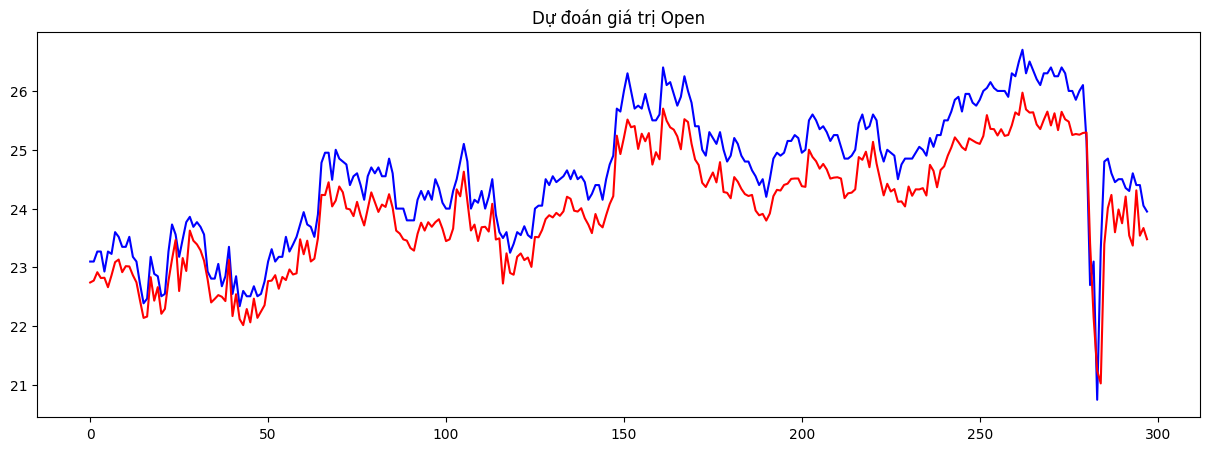

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 0], label='Giá thực tế', color='blue')
plt.plot(y_pred[:, 0], label='Giá dự đoán', color='red')
plt.title('Dự đoán giá trị Open')
plt.show()

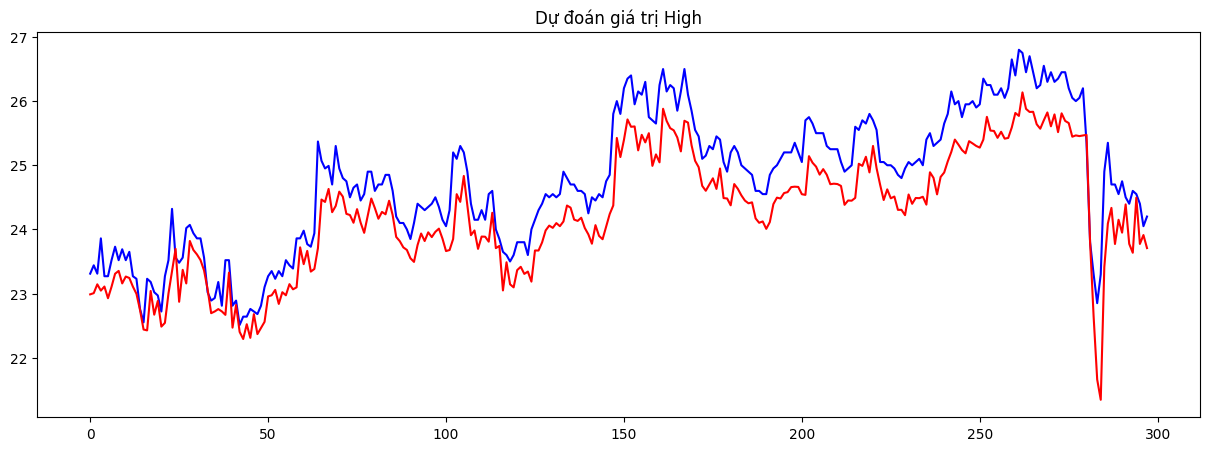

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 1], label='Giá thực tế', color='blue')
plt.plot(y_pred[:, 1], label='Giá dự đoán', color='red')
plt.title('Dự đoán giá trị High')
plt.show()

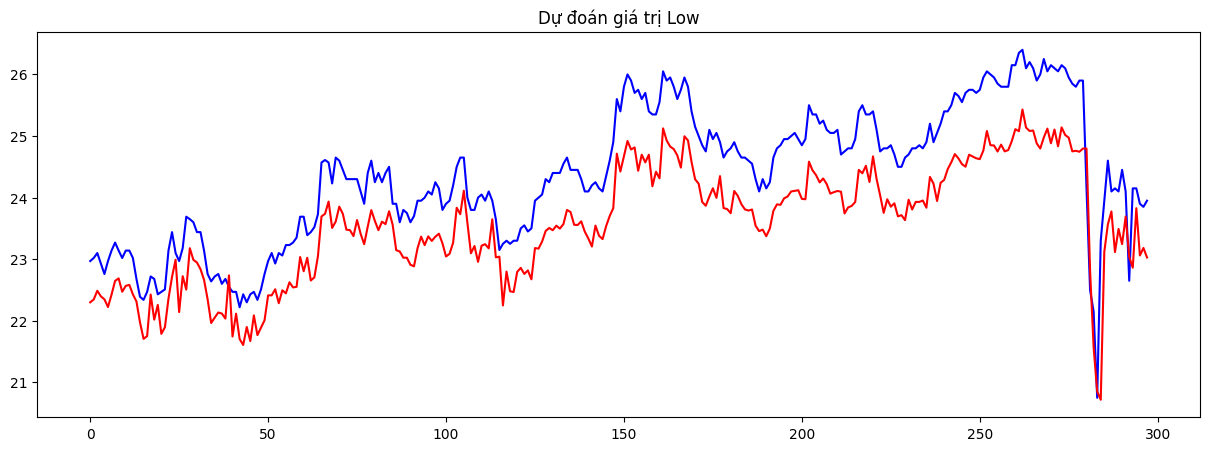

In [10]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 2], label='Giá thực tế', color='blue')
plt.plot(y_pred[:, 2], label='Giá dự đoán', color='red')
plt.title('Dự đoán giá trị Low')
plt.show()

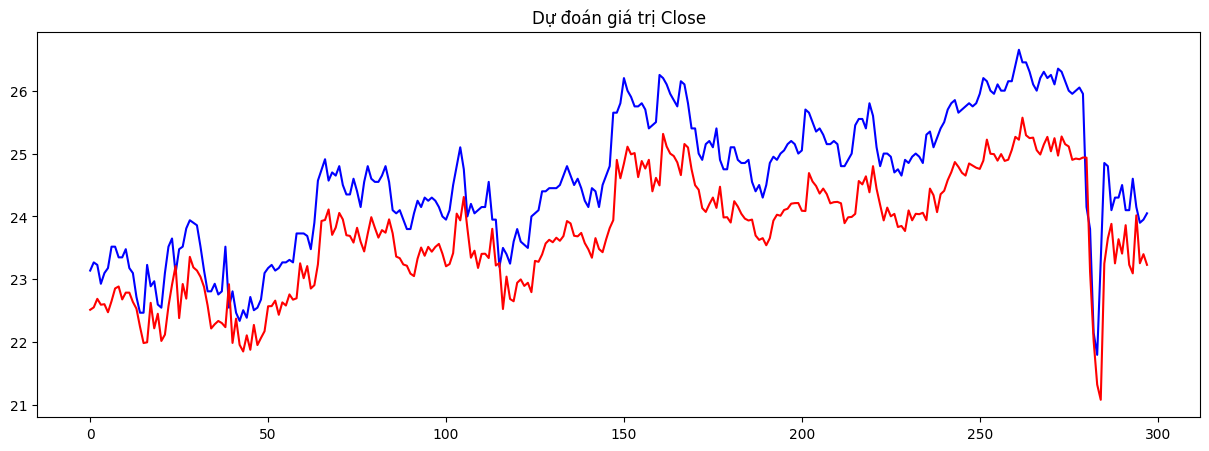

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 3], label='Giá thực tế', color='blue')
plt.plot(y_pred[:, 3], label='Giá dự đoán', color='red')
plt.title('Dự đoán giá trị Close')
plt.show()

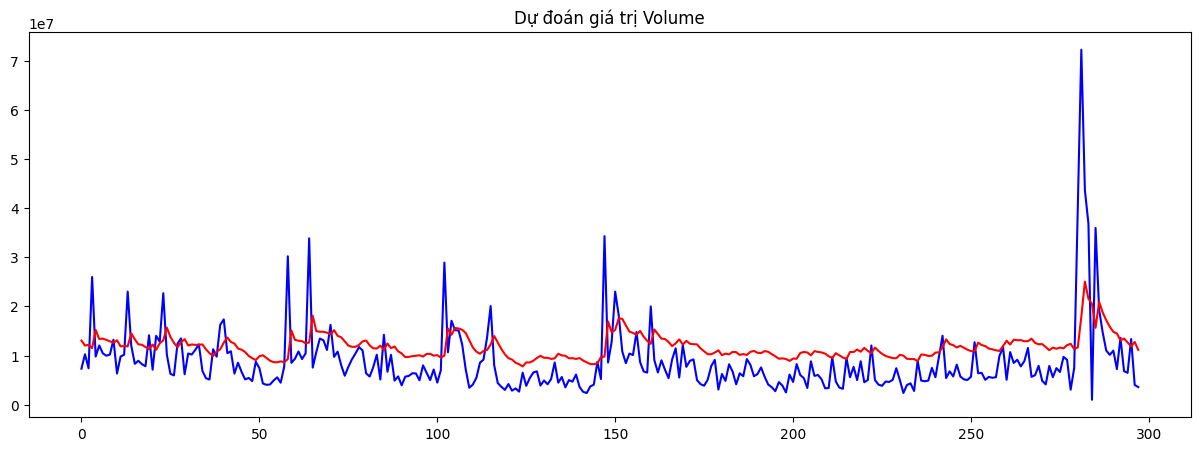

In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 4], label='Giá thực tế', color='blue')
plt.plot(y_pred[:, 4], label='Giá dự đoán', color='red')
plt.title('Dự đoán giá trị Volume')
plt.show()